In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load reviews (JSONL format)
reviews_df = pd.read_json("Handmade_Products.jsonl", lines=True)
meta_df = pd.read_json("meta_Handmade_Products.jsonl", lines=True)

/var/folders/97/39v4q5d17f39bcmmkl55tr940000gn/T/ipykernel_75214/18347471.py:2: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  reviews_df = pd.read_json("Handmade_Products.jsonl", lines=True)


ValueError: Expected object or value

In [3]:

# Count how many reviews each parent_asin has
review_counts = reviews_df['parent_asin'].value_counts() #parent_asin is a unique id for each product

# Filter for products with at least 20 reviews
popular_parents = review_counts[review_counts >= 20].index.tolist()
print(f"Found {len(popular_parents)} products with >= 20 reviews")

# Select the first 10 parent_asins
selected_parents = popular_parents[:10]

# Filter review DataFrame to only include those 10 products
filtered_reviews = reviews_df[reviews_df['parent_asin'].isin(selected_parents)]

# Merge with metadata to get product names
meta_df_subset = meta_df[['title', 'parent_asin']]
merged_df = pd.merge(filtered_reviews, meta_df_subset, on='parent_asin', how='left')
print(merged_df.columns.tolist())

# Show counts + sample reviews with product names
print("\nNumber of reviews per product:")
print(merged_df['title_y'].value_counts()) #using title_y because both meta data and original data have 'title'

# Sample reviews of popular products with their names
print("\nSample reviews with product names:")
print(merged_df[['title_y', 'rating', 'text']].head(10))

Found 4930 products with >= 20 reviews
['rating', 'title_x', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'title_y']

Number of reviews per product:
title_y
Cats Dogs ID Tags Personalized Lovely Symbols Pets Collar Name Accessories Simple Custom Engraved Products for Medium Four Legged Child Necklace Chain Anti-Lost Copper Shiny Brass Charm                   2498
Custom Star Map - Personalized Star Map (Multiple Sizes - Unframed Star Prints, Star Constellation Map Wall Art, Great Gift - Special Occasion, Engagement Gift, Wedding Gift, Anniversary Gift)            1305
Personalized Custom Wooden Name Sign - CHARLOTTE Font Baby Name Sign For Nursery and Wall Decor (12"-55" Wide) - PAINTED Wood Letter Nursery Decor - Wall Art For Girl or Boy Room By 48 Hour Monogram      1088
The Original BenShot Bullet Rocks Glass with Real .308 Bullet - 11oz | Made in the USA                                                                         

In [4]:
#Avg rating and review count of each product
rating_summary = (
    merged_df.groupby('title_y')
    .agg(avg_rating=('rating', 'mean'), review_count=('rating', 'count'))
    .round(2)
    .sort_values(by='avg_rating', ascending=False)
)

print("Product Ratings and Review Counts:")
print(rating_summary)


Product Ratings and Review Counts:
                                                    avg_rating  review_count
title_y                                                                     
Custom Star Map - Personalized Star Map (Multip...        4.92          1305
The Original BenShot Bullet Rocks Glass with Re...        4.92          1044
Custom Metal Signs | Metal Name Sign | Metal Wa...        4.79           766
Cats Dogs ID Tags Personalized Lovely Symbols P...        4.66          2498
Personalized Custom Wooden Name Sign - CHARLOTT...        4.56          1088
Personalized Customizable Necklace Women Mother...        4.30           734
Triple Protection Bracelet - For Protection - B...        4.29           896
MARBLEFY Custom Name Airpod Pro Case with Keych...        3.85           913
Baby Name Bar id Bracelet Baby Gift Personalize...        3.55           972
16K Gold Your Name Bar Bracelet - Personalized ...        3.45           887


In [5]:
# Create a mapping from parent_asin to product name
id_to_title = merged_df[['parent_asin', 'title_y']].drop_duplicates().set_index('parent_asin')['title_y'].to_dict()
#Truncating titles to shorten them - makes it a bit easier to interpret in the next steps
def truncate_title(title, max_words=5):
    return ' '.join(title.split()[:max_words]) + "..." if len(title.split()) > max_words else title

short_title_map = {pid: truncate_title(name) for pid, name in id_to_title.items()}
merged_df['short_title'] = merged_df['parent_asin'].map(short_title_map)

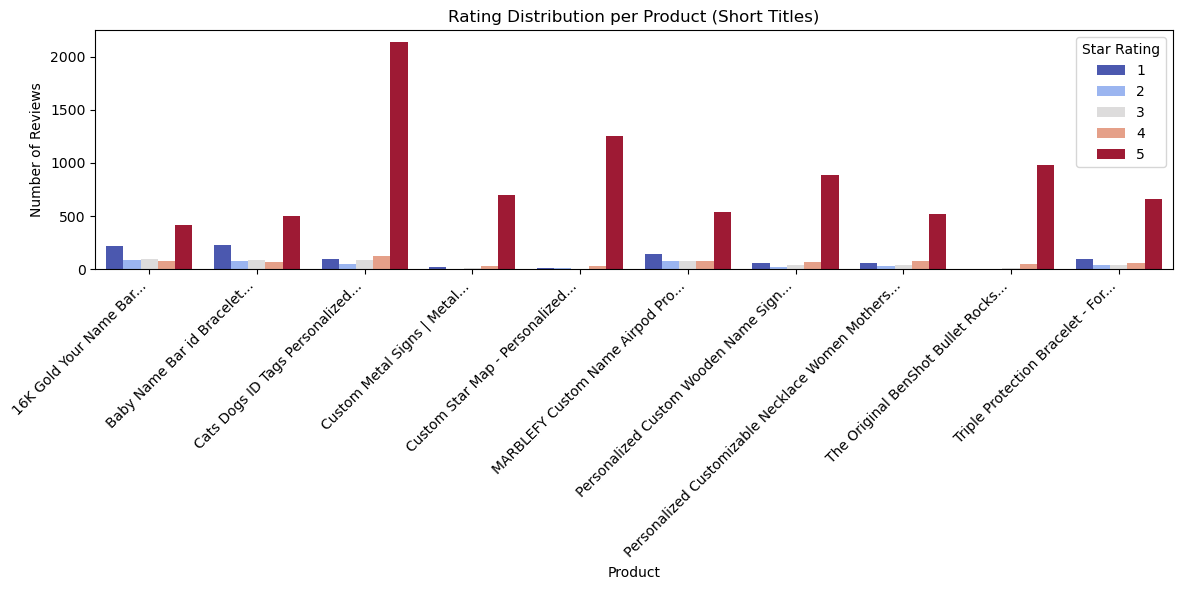

In [6]:
# Filter only selected products (optional, using short titles)
subset_df = merged_df[merged_df['parent_asin'].isin(selected_parents)]

# Group by short_title and rating
rating_dist = subset_df.groupby(['short_title', 'rating']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=rating_dist, x='short_title', y='count', hue='rating', palette='coolwarm')

plt.title('Rating Distribution per Product (Short Titles)')
plt.xlabel('Product')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Star Rating')
plt.tight_layout()
plt.show()

/var/folders/97/39v4q5d17f39bcmmkl55tr940000gn/T/ipykernel_27053/3269004066.py:19: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/97/39v4q5d17f39bcmmkl55tr940000gn/T/ipykernel_27053/3269004066.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


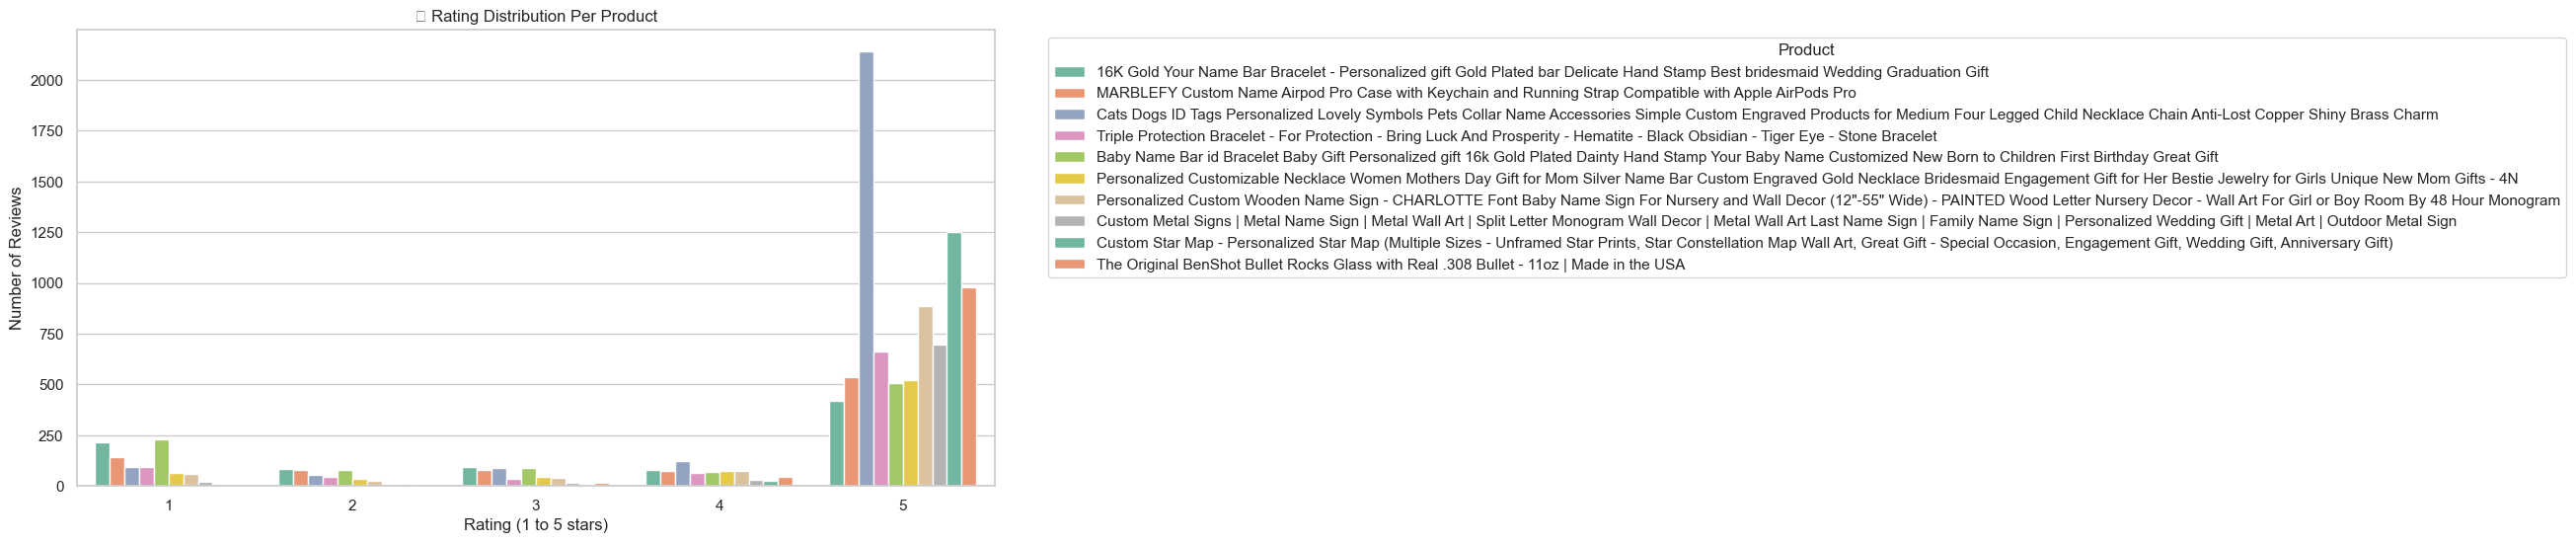

In [7]:


# Filter to selected products only
selected_titles = merged_df[merged_df['parent_asin'].isin(selected_parents)]['title_y'].unique()
filtered = merged_df[merged_df['title_y'].isin(selected_titles)]

# Set the plot style
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(12, 6))

# Plot: count of ratings per product
sns.countplot(data=filtered, x="rating", hue="title_y", palette="Set2")

# Improve readability
plt.title("⭐ Rating Distribution Per Product")
plt.xlabel("Rating (1 to 5 stars)")
plt.ylabel("Number of Reviews")
plt.legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [8]:
# Load the pretrained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Setting an initial dictionary to store embeddings per method
simple_avg_embeddings = {}
rating_weighted_embeddings = {}
helpful_embeddings = {}

# Loop through each selected parent_asin (unique id for each product)
for parent_id in selected_parents:
    product_reviews = merged_df[merged_df['parent_asin'] == parent_id]

    #Getting review texts and ratings
    texts = product_reviews['text'].astype(str).tolist()
    ratings = product_reviews['rating'].tolist()
    
    #Getting Helpful vote counts 
    if 'helpful_vote' in product_reviews.columns:
        helpfulness = product_reviews['helpful_vote'].fillna(1).tolist()
    else:
        helpfulness = [1] * len(texts)
    
    # Get review lengths
    review_lengths = [len(t.split()) for t in texts]
    
    # Generate embeddings
    review_embeddings = model.encode(texts)

    # Method 1: Simple Average
    simple_avg = np.mean(review_embeddings, axis=0)
    simple_avg_embeddings[parent_id] = simple_avg

    # Method 2: Rating-Weighted Average
    ratings_array = np.array(ratings).reshape(-1, 1)
    weighted = np.average(review_embeddings, axis=0, weights=ratings_array.flatten())
    rating_weighted_embeddings[parent_id] = weighted

    # Method 3: Helpfulness-Weighted Average
    helpfulness_array = np.array(helpfulness).reshape(-1, 1) #helpfulness array contains how many users marked a review as helpful
    helpful_avg = np.average(review_embeddings, axis=0, weights=helpfulness_array.flatten())
    helpful_embeddings[parent_id] = helpful_avg

In [9]:
#Confirming everything worked and printing product ID's for the popular products
    #Also printing the shape of the embedding
# Create a mapping from parent_asin to product name
#id_to_title = merged_df[['parent_asin', 'title_y']].drop_duplicates().set_index('parent_asin')['title_y'].to_dict()

print("Simple Avg Embeddings:", list(simple_avg_embeddings.keys()))
print("Shape of one embedding:", simple_avg_embeddings[selected_parents[0]].shape)

Simple Avg Embeddings: ['B09GK2JJDZ', 'B07RC9FWLN', 'B01G29HQ8G', 'B01ASDYQQC', 'B01N5SVHUU', 'B083Q2N1KQ', 'B07NP52Y1F', 'B015NSJ11W', 'B081732LNJ', 'B015HVACEA']
Shape of one embedding: (384,)


In [10]:
#Finding similar products using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_products(embedding_dict, id_to_title, method_name="Simple Avg"):
    print(f"\nTop 3 Similar Products ({method_name}):")

    product_ids = list(embedding_dict.keys())
    embed_matrix = np.array([embedding_dict[pid] for pid in product_ids])
    # creating a similarity matrix - a comparison, product by product that compares how similar their review embeddings are
    similarity_matrix = cosine_similarity(embed_matrix)

    for i, product_id in enumerate(product_ids): #loops through each product id and compares review embeddings
        product_name = id_to_title.get(product_id, product_id)
        similarities = similarity_matrix[i]

        # Get top 3 similar products (excluding the product itself)
        similar_indices = similarities.argsort()[-4:-1][::-1]

        #print results
        print(f"\nProducts similar to:\n {product_name}")
        for idx in similar_indices:
            sim_product_id = product_ids[idx]
            sim_score = similarities[idx]
            sim_name = id_to_title.get(sim_product_id, sim_product_id)
            print(f"  → {sim_name}: similarity = {sim_score:.4f}")

#Calling the similarity function using our three aggregation methods
find_similar_products(simple_avg_embeddings, id_to_title, "Simple Avg")
find_similar_products(rating_weighted_embeddings, id_to_title, "Rating Weighted")
find_similar_products(helpful_embeddings, id_to_title, "Helpfulness Weighted")



Top 3 Similar Products (Simple Avg):

Products similar to:
 Cats Dogs ID Tags Personalized Lovely Symbols Pets Collar Name Accessories Simple Custom Engraved Products for Medium Four Legged Child Necklace Chain Anti-Lost Copper Shiny Brass Charm
  → Personalized Custom Wooden Name Sign - CHARLOTTE Font Baby Name Sign For Nursery and Wall Decor (12"-55" Wide) - PAINTED Wood Letter Nursery Decor - Wall Art For Girl or Boy Room By 48 Hour Monogram: similarity = 0.7791
  → 16K Gold Your Name Bar Bracelet - Personalized gift Gold Plated bar Delicate Hand Stamp Best bridesmaid Wedding Graduation Gift: similarity = 0.7761
  → Baby Name Bar id Bracelet Baby Gift Personalized gift 16k Gold Plated Dainty Hand Stamp Your Baby Name Customized New Born to Children First Birthday Great Gift: similarity = 0.7691

Products similar to:
 Custom Star Map - Personalized Star Map (Multiple Sizes - Unframed Star Prints, Star Constellation Map Wall Art, Great Gift - Special Occasion, Engagement Gift, Weddin

In [11]:
#Finding similar products using euclidean distance
from sklearn.metrics.pairwise import euclidean_distances

#defining function for finding similarities
def find_similar_products_euclidean(embedding_dict, id_to_title, method_name="Simple Avg"):
    print(f"\nTop 3 Similar Products (Euclidean - {method_name}):")

    product_ids = list(embedding_dict.keys())
    embed_matrix = np.array([embedding_dict[pid] for pid in product_ids])
    #similar concept as above, except we're using euclidean distance
    distance_matrix = euclidean_distances(embed_matrix)

    #creating a distance matrix- compares product by product and calculates distance between review embeddings
    for i, product_id in enumerate(product_ids):
        product_name = id_to_title.get(product_id, product_id)
        distances = distance_matrix[i]

        # Get top 3 closest (excluding itself)
        similar_indices = distances.argsort()[1:4]

        #print the most similar products (top 3)
        print(f"\nProducts closest to:\n {product_name}")
        for idx in similar_indices:
            sim_product_id = product_ids[idx]
            sim_dist = distances[idx]
            sim_name = id_to_title.get(sim_product_id, sim_product_id)
            print(f"  → {sim_name}: distance = {sim_dist:.4f}")

find_similar_products_euclidean(simple_avg_embeddings, id_to_title, "Simple Avg")
find_similar_products_euclidean(rating_weighted_embeddings, id_to_title, "Rating Weighted")
find_similar_products_euclidean(helpful_embeddings, id_to_title, "Helpfulness Weighted")
    
             


Top 3 Similar Products (Euclidean - Simple Avg):

Products closest to:
 Cats Dogs ID Tags Personalized Lovely Symbols Pets Collar Name Accessories Simple Custom Engraved Products for Medium Four Legged Child Necklace Chain Anti-Lost Copper Shiny Brass Charm
  → Personalized Custom Wooden Name Sign - CHARLOTTE Font Baby Name Sign For Nursery and Wall Decor (12"-55" Wide) - PAINTED Wood Letter Nursery Decor - Wall Art For Girl or Boy Room By 48 Hour Monogram: distance = 0.3502
  → Baby Name Bar id Bracelet Baby Gift Personalized gift 16k Gold Plated Dainty Hand Stamp Your Baby Name Customized New Born to Children First Birthday Great Gift: distance = 0.3542
  → 16K Gold Your Name Bar Bracelet - Personalized gift Gold Plated bar Delicate Hand Stamp Best bridesmaid Wedding Graduation Gift: distance = 0.3581

Products closest to:
 Custom Star Map - Personalized Star Map (Multiple Sizes - Unframed Star Prints, Star Constellation Map Wall Art, Great Gift - Special Occasion, Engagement Gift, 

In [12]:
#calculating average review length (in words) for each selected product

# Add a review length column
merged_df['review_length'] = merged_df['text'].astype(str).apply(lambda x: len(x.split()))

#group by product title (or parent_asin) and calculate the average review length
avg_lengths = merged_df.groupby('title_y')['review_length'].mean().sort_values()

print(avg_lengths)


title_y
Baby Name Bar id Bracelet Baby Gift Personalized gift 16k Gold Plated Dainty Hand Stamp Your Baby Name Customized New Born to Children First Birthday Great Gift                                            19.304527
The Original BenShot Bullet Rocks Glass with Real .308 Bullet - 11oz | Made in the USA                                                                                                                      20.894636
MARBLEFY Custom Name Airpod Pro Case with Keychain and Running Strap Compatible with Apple AirPods Pro                                                                                                      21.375685
Custom Metal Signs | Metal Name Sign | Metal Wall Art | Split Letter Monogram Wall Decor | Metal Wall Art Last Name Sign | Family Name Sign | Personalized Wedding Gift | Metal Art | Outdoor Metal Sign    21.652742
Personalized Customizable Necklace Women Mothers Day Gift for Mom Silver Name Bar Custom Engraved Gold Necklace Bridesmaid Engagement Gi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


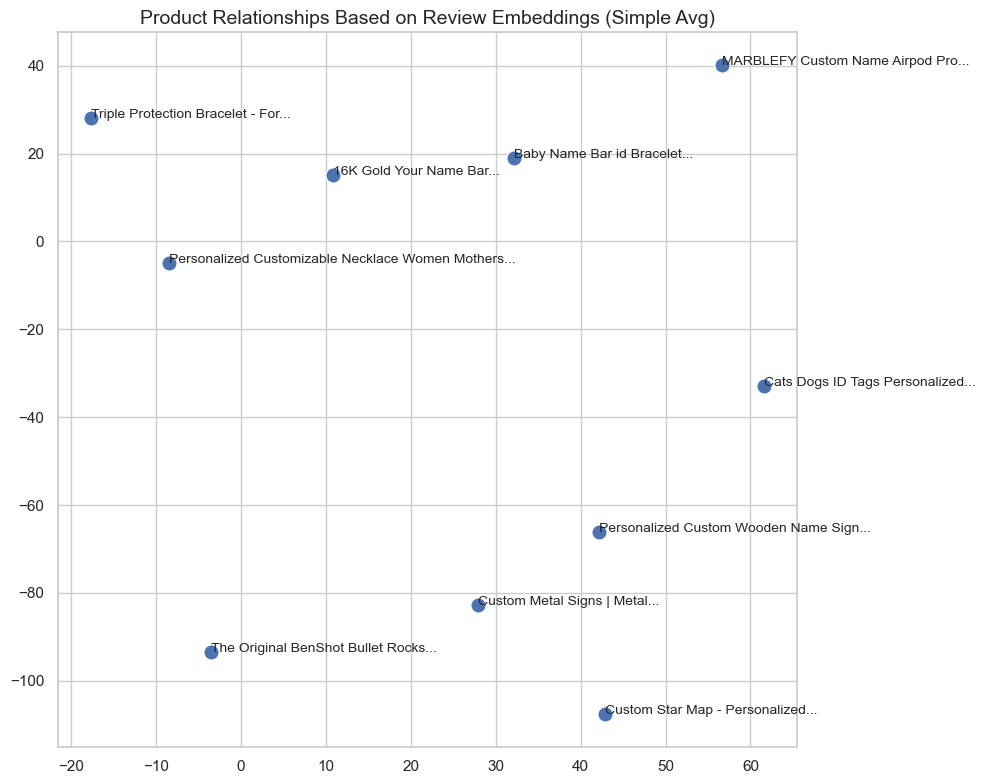

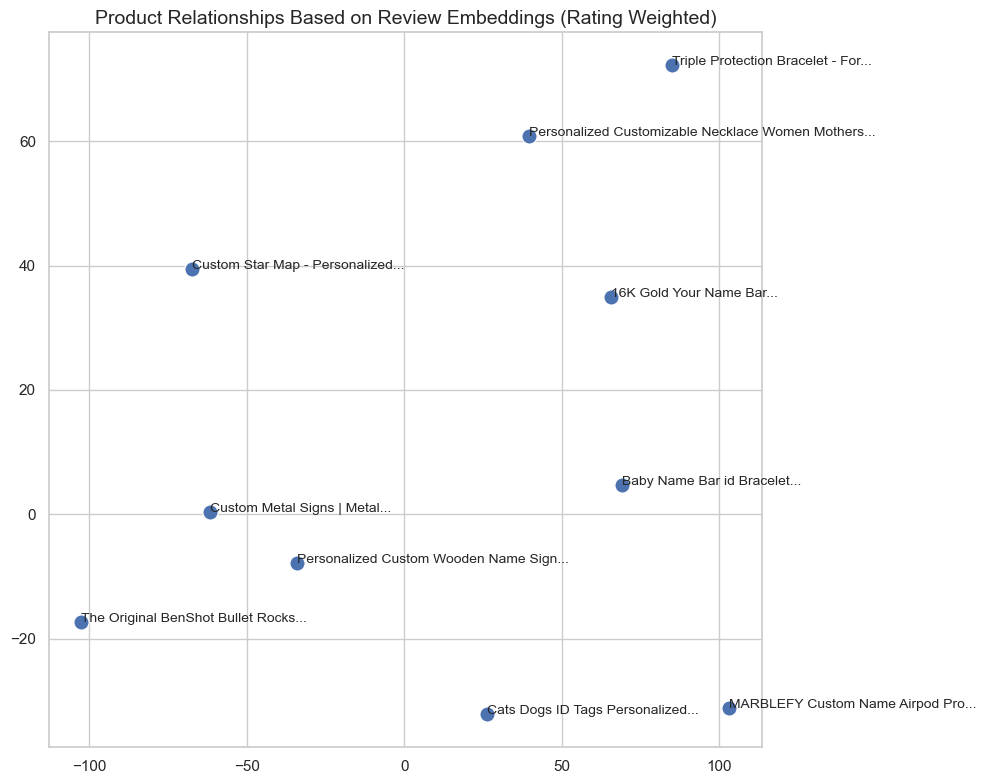

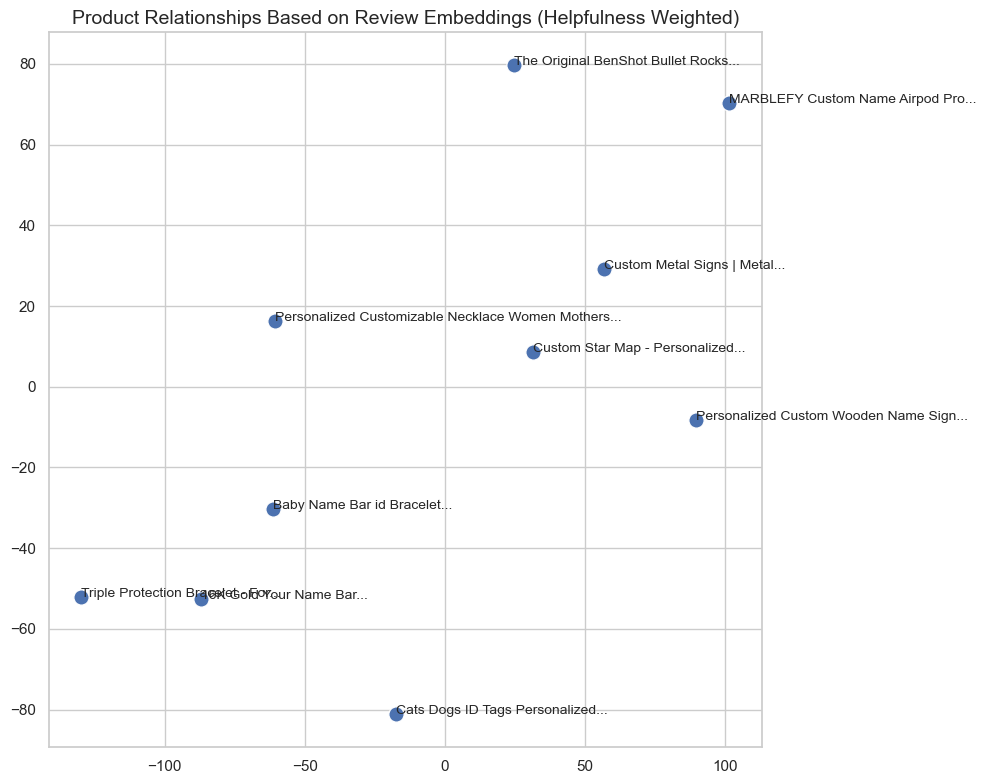

In [13]:
from sklearn.manifold import TSNE

def visualize_embeddings(embedding_dict, short_title_map, method_name="Simple Avg"):
    product_ids = list(embedding_dict.keys()) #list of product ids
    product_names = [short_title_map.get(pid, pid) for pid in product_ids] #list of product names
    embed_matrix = np.array([embedding_dict[pid] for pid in product_ids]) #embedding matrix

    # Reduce dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=3) #perplexity is related to # nearest neighbors
    embeddings_2d = tsne.fit_transform(embed_matrix)

    # Create plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], s=120)

    # Add product labels using the product names
    for i, name in enumerate(product_names):
        plt.annotate(name, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=10)

    plt.title(f"Product Relationships Based on Review Embeddings ({method_name})", fontsize=14)
    plt.tight_layout()
    plt.savefig(f"product_embedding_visualization_{method_name.replace(' ', '_')}.png", dpi=300)
    plt.show()

visualize_embeddings(simple_avg_embeddings, short_title_map, "Simple Avg")
visualize_embeddings(rating_weighted_embeddings, short_title_map, "Rating Weighted")
visualize_embeddings(helpful_embeddings, short_title_map, "Helpfulness Weighted")

